In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [2]:
from ranking_funcs import Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

In [3]:
df=read_data('German.csv')

installment_plans
number_of_credits
employment
housing
credit_history
skill_level


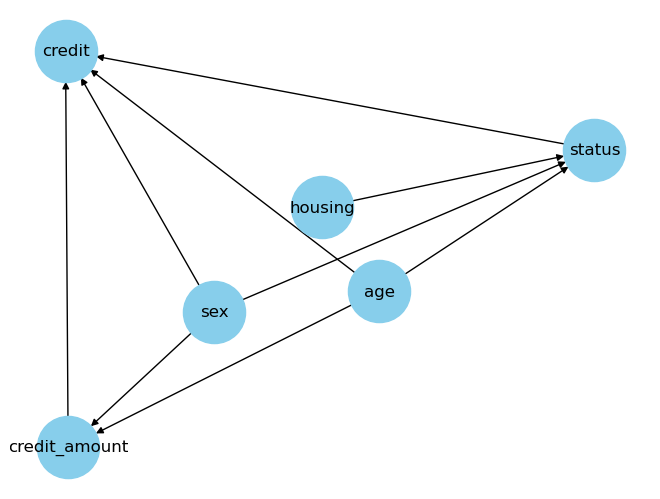

In [4]:
G = nx.DiGraph()


nodes = ['sex', 'status', 'credit_amount', 'credit', 'age', 'housing']
G.add_nodes_from(nodes)

G.add_edges_from([('sex', 'status'), ('sex', 'credit_amount'), ('sex', 'credit'),
                  ('housing', 'status'), ('age', 'status'), 
                  ('age', 'credit'), ('age', 'credit_amount'),('credit_amount', 'credit'),('status', 'credit')])


pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue")
plt.show()

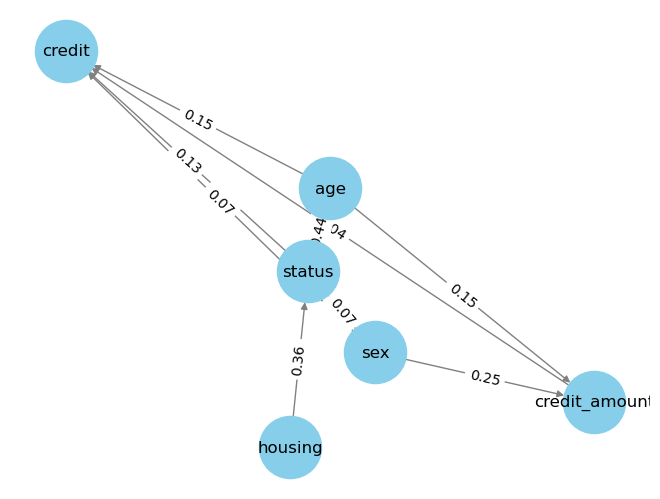

In [5]:
new_G=get_new_G(G,df)
pos = nx.spring_layout(new_G)
nx.draw(new_G, pos, with_labels=True, node_size=2000, node_color="skyblue", 
        edge_color="grey", width=1)

edge_labels = {(u, v): f"{data['weight']:.2f}" for u, v, data in new_G.edges(data=True)}
nx.draw_networkx_edge_labels(new_G, pos, edge_labels=edge_labels)
plt.show()

In [6]:
ranks=get_ranking_query(new_G, df, 5, {'housing':1}, 'credit_amount',{'age':1},'fix')
ranks

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
5,3,1.0,1.046003,1,3,0,2.0,5.0,1.0,1,...,2.0,3.0,0.0,2.0,2.0,1.0,0,3.359667,0.0,2
1,3,0.0,0.000000,1,3,0,2.0,4.0,0.0,1,...,2.0,0.0,0.0,2.0,1.0,0.0,0,1.000000,2.0,0
7,3,1.0,1.046003,1,3,0,2.0,2.0,1.0,1,...,2.0,2.0,0.0,2.0,1.0,1.0,0,1.359667,3.0,0
3,3,1.0,1.046003,1,3,0,3.0,3.0,1.0,1,...,2.0,1.0,0.0,2.0,2.0,0.0,1,0.359667,2.0,0
17,3,0.0,1.000000,0,3,1,0.0,5.0,1.0,1,...,0.0,2.0,0.0,2.0,1.0,0.0,0,0.000000,2.0,2


### Simulating the ranking probility

In [7]:
base_line(df,5)

1.0100653517088042e-15

#### Backdoor adjustment probs

In [8]:
cgm=get_cgm(new_G)

In [9]:
%%time
df_back_prob=get_prob_backdoor_opt(get_ranking_query(new_G, df, len(df), {'housing':1}, 'credit_amount',{'age':1},'fix'),cgm,'credit_amount')

CPU times: user 887 ms, sys: 109 ms, total: 996 ms
Wall time: 643 ms


In [10]:
df_back_prob

,Y,Y_value,X,X_value,Z,prob
0,credit_amount,0,sex,1.0,"status, age",0.276128
1,credit_amount,0,sex,0.0,"status, age",0.389690
2,credit_amount,3,sex,1.0,"status, age",0.187772
3,credit_amount,3,sex,0.0,"status, age",0.114527
4,credit_amount,1,sex,1.0,"status, age",0.323770
...,...,...,...,...,...,...
259,credit_amount,3,housing,0.0,sex,0.063393
260,credit_amount,1,housing,1.0,sex,0.313544
261,credit_amount,1,housing,0.0,sex,0.335000
262,credit_amount,2,housing,1.0,sex,0.209564


In [11]:
sorted_df = df_back_prob.sort_values(by=['Y_value', 'prob'], ascending=[False, False])
sorted_df

,Y,Y_value,X,X_value,Z,prob
61,credit_amount,3,status,1.359667,"sex, age, housing",0.391056
93,credit_amount,3,status,1.359667,"sex, age",0.391056
135,credit_amount,3,credit,0.046003,"housing, age, sex",0.308532
167,credit_amount,3,credit,0.046003,"sex, age",0.308532
59,credit_amount,3,status,0.359667,"sex, age, housing",0.217573
...,...,...,...,...,...,...
233,credit_amount,0,housing,0.000000,"sex, age",0.064375
115,credit_amount,0,credit,0.046003,"status, housing, age, sex",0.048423
147,credit_amount,0,credit,0.046003,"status, sex, age",0.048423
114,credit_amount,0,credit,1.046003,"status, housing, age, sex",0.033511


In [12]:
ranks_prob=get_ranking_query_prob(new_G, df, 5, {'housing':1}, 'credit_amount',{'age':1},'fix')
ranks_prob

,row_index,1,2,3,4,5
0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.005952,0.005952,0.005952,0.005952,0.005952
2,2,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.005952,0.005952,0.005952,0.005952,0.005952
4,4,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
995,995,0.000000,0.000000,0.000000,0.000000,0.000000
996,996,0.000000,0.000000,0.000000,0.000000,0.000000
997,997,0.000000,0.000000,0.000000,0.000000,0.000000
998,998,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
ranks_prob_filtered=filter_prob_df(ranks_prob)
ranks_prob_filtered

,row_index,1,2,3,4,5
1,1,0.005952,0.005952,0.005952,0.005952,0.005952
3,3,0.005952,0.005952,0.005952,0.005952,0.005952
5,5,0.005952,0.005952,0.005952,0.005952,0.005952
7,7,0.005952,0.005952,0.005952,0.005952,0.005952
17,17,0.005952,0.005952,0.005952,0.005952,0.005952
...,...,...,...,...,...,...
973,973,0.005952,0.005952,0.005952,0.005952,0.005952
980,980,0.005952,0.005952,0.005952,0.005952,0.005952
983,983,0.005952,0.005952,0.005952,0.005952,0.005952
986,986,0.005952,0.005952,0.005952,0.005952,0.005952


In [14]:
get_probs(ranks_prob,[1, 3, 5, 7, 17])

7.934843523730395e-12

### Update housing to divided by 2 for age=1 to rank the credit_amount

In [15]:
ranks_prob_add=get_ranking_query(new_G, df, 5, {'housing':2}, 'credit_amount',{'age':1},'add')
ranks_prob_add

,month,age,credit,installment_plans,credit_amount,number_of_credits,employment,purpose,sex,housing,...,credit_history,property,foreign_worker,investment_as_income_percentage,people_liable_for,telephone,other_debtors,status,skill_level,savings
5,3,1.0,1.092007,1,3,0,2.0,5.0,1.0,2,...,2.0,3.0,0.0,2.0,2.0,1.0,0,3.719334,0.0,2
1,3,0.0,0.000000,1,3,0,2.0,4.0,0.0,1,...,2.0,0.0,0.0,2.0,1.0,0.0,0,1.000000,2.0,0
7,3,1.0,1.092007,1,3,0,2.0,2.0,1.0,2,...,2.0,2.0,0.0,2.0,1.0,1.0,0,1.719334,3.0,0
3,3,1.0,1.092007,1,3,0,3.0,3.0,1.0,2,...,2.0,1.0,0.0,2.0,2.0,0.0,1,0.719334,2.0,0
17,3,0.0,1.000000,0,3,1,0.0,5.0,1.0,1,...,0.0,2.0,0.0,2.0,1.0,0.0,0,0.000000,2.0,2


### Greedy algorithm

In [16]:
var=['sex', 'status', 'credit', 'age', 'housing']

In [17]:
df_gr=Greedy_Algo(new_G, df, 5, 'credit_amount',var,0, {'age':1},100, opt="add",force=0.5)

In [18]:
df_gr

,rank,prob,total_iters
0,"[5, 18, 7, 3, 29]",0.204,102.0
1,"[5, 7, 18, 3, 29]",0.098,49.0
2,"[7, 5, 18, 3, 29]",0.098,49.0
3,"[5, 1, 7, 3, 17]",0.600,300.0


In [19]:
get_most_probable_elements(df_gr)

,element,prob,total_iters
0,3,1.0,500.0
1,5,1.0,500.0
2,7,1.0,500.0
3,18,0.4,200.0
4,29,0.4,200.0
5,1,0.6,300.0
6,17,0.6,300.0
